In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = 'CNN_learn_pytorch_MNIST_v2.pth'
use_cuda=True

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) #input size, ouptut size, filer(kernel) size
        self.pool = nn.MaxPool2d(2,2) # size of pool, and then the stride of the pool
        self.conv2 = nn.Conv2d(6,16,5) # conv1 ouput size = conv2 input size
        self.fc1 = nn.Linear(16*4*4, 120)
        # 16*5*5 becasue after conv2, the output size is 4(batch_size),16(num_filters),5,5(l,w)
        #we have to flatten the thing for lin reg, so thats why we change the input size
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # conv layers
        out = self.conv1(x)
        out = self.relu(out)
        out = self.pool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.pool(out)
        
        #flatten to pass to linear layers
        out = out.view(-1,16*4*4)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        
        return out




test_dataset = torchvision.datasets.MNIST(root ='./data', train= False, download=True, transform = transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
    

device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

model = ConvNet().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model.eval()
criterion = nn.CrossEntropyLoss()

In [4]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [10]:
def test( model, device, test_loader, epsilon ):

    num_correct = 0

    for data, label in test_loader:

        
        data = data.to(device)
        label = label.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        
        index, pred = torch.max(output,1)

        # If the initial prediction is wrong, dont bother attacking, just move on
        if pred.item() != label.item():
            continue

        # Calculate the loss
        loss = criterion(output, label)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_index, final_pred = torch.max(output,1)
        if final_pred.item() == label.item():
            num_correct += 1


    # Calculate final accuracy for this epsilon
    final_acc = 100.0 * num_correct/len(test_loader) 
    print(f"Epsilon: {epsilon}\tTest Accuracy = {num_correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc

In [6]:
accuracies = []


# Run test for each epsilon
for eps in epsilons:
    acc = test(model, device, test_loader, eps)
    accuracies.append(acc)
    


Epsilon: 0	Test Accuracy = 9873 / 10000 = 98.73
Epsilon: 0.05	Test Accuracy = 8999 / 10000 = 89.99
Epsilon: 0.1	Test Accuracy = 7230 / 10000 = 72.3
Epsilon: 0.15	Test Accuracy = 5001 / 10000 = 50.01
Epsilon: 0.2	Test Accuracy = 3149 / 10000 = 31.49
Epsilon: 0.25	Test Accuracy = 1972 / 10000 = 19.72
Epsilon: 0.3	Test Accuracy = 1354 / 10000 = 13.54


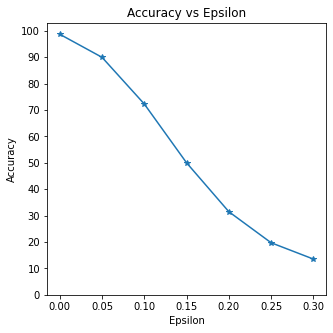

In [8]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 110, step=10))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()